# アドバンスドビジョンレポート
## 25S1037_藤澤秀一郎

# 1 オートエンコーダ
## 1.1 オートエンコーダとは
### オートエンコーダはエンコーダとデコーダで構成されたANNであり、エンコーダでは入力されたデータの次元数を圧縮し、デコーダではその圧縮されたデータをもとのデータサイズまで復元する。この際に入力と出力が同じになるように学習させることで入力データを表す本質的な変数を得ることができる。
## 1.2 作成するオートエンコーダの仕様
### データ
#### MNIATデータセットを使用する。28×28ピクセルのモノクロ手書き数字[1, 28, 28]
### エンコーダ
#### 隠れ層が一つの合計三層のネットワーク
### デコーダ
#### 隠れ層が一つの合計三層のネットワーク
### 活性化関数
#### ReLU関数とsigmoid関数を使う。デコーダの出力にはsigmoido関数を使いそれ以外にはReLU関数を使う。
### 損失関数
#### クロスエントロピー誤差を用いて定義(式1.1)
$$ H(p,q) = -\sum_{i=1}^n p(x_{i})\log(q(x_i)\tag{1.1}$$
### 学習
#### 誤差逆伝搬法

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.animation as animation
from matplotlib import animation, rc

In [52]:
BATCH_SIZE = 100

trainval_data = MNIST("./data", 
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor())

train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

print("train data size: ",len(train_data))   #train data size:  48000
print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  480
print("val data size: ",len(val_data))   #val data size:  12000
print("val iteration number: ",len(val_data)//BATCH_SIZE)   #val iteration number:  120


train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


images_size: torch.Size([100, 1, 28, 28])
label: tensor([0, 2, 6, 4, 8, 6, 9, 7, 3, 6])
cpu


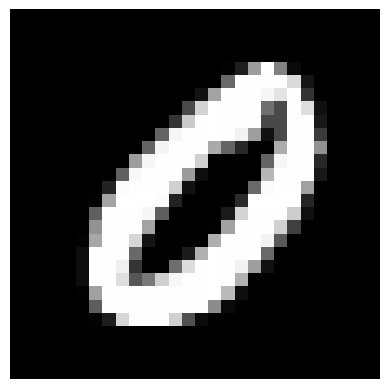

In [53]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([100, 1, 28, 28])
print("label:",labels[:10])   #label: tensor([7, 6, 0, 6, 4, 8, 5, 2, 2, 3])
print(images.device)

image_numpy = images.detach().numpy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')
plt.axis('off')
plt.show()


In [54]:
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr3 = nn.Linear(100, z_dim) #mean
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    return x

class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)
    return x

class AE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z = self.encoder(x)
    x = self.decoder(z)
    return x, z


In [55]:
def criterion_ae(predict, target):
  loss = F.binary_cross_entropy(predict, target, reduction='sum')
  return loss

# 学習開始

In [56]:
z_dim = 2
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = AE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = {"train_loss": [], "val_loss": [], "z": [], "labels":[]}

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)
for epoch in range(num_epochs):
  model.train()
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 28*28).to(torch.float32)
    output, z = model(input)

    history["z"].append(z)
    history["labels"].append(labels)
    loss = criterion_ae(output, input)
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    if (i+1) % 50 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    history["train_loss"].append(loss)

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      output, z = model(input)

      loss = criterion_ae(output, input)
      history["val_loss"].append(loss)
      
    print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')
  
  scheduler.step()


Epoch: 1, loss:  21858.1758
Epoch: 1, loss:  18308.2539
Epoch: 1, loss:  18314.5605
Epoch: 1, loss:  17042.3496
Epoch: 1, loss:  16841.6699
Epoch: 1, loss:  17012.9219
Epoch: 1, loss:  15755.1035
Epoch: 1, loss:  15868.1719
Epoch: 1, loss:  16522.0996
Epoch: 1, val_loss:  15957.4707
Epoch: 2, loss:  15901.7617
Epoch: 2, loss:  15229.2588
Epoch: 2, loss:  15752.7266
Epoch: 2, loss:  15212.4512
Epoch: 2, loss:  14886.8223
Epoch: 2, loss:  15129.8496
Epoch: 2, loss:  14895.3262
Epoch: 2, loss:  15904.4551
Epoch: 2, loss:  15607.6436
Epoch: 2, val_loss:  15352.7793
Epoch: 3, loss:  14969.0273
Epoch: 3, loss:  15944.3896
Epoch: 3, loss:  14374.1699
Epoch: 3, loss:  16126.2432
Epoch: 3, loss:  15270.7568
Epoch: 3, loss:  14213.4316
Epoch: 3, loss:  14377.9951
Epoch: 3, loss:  14677.3965
Epoch: 3, loss:  14489.5869
Epoch: 3, val_loss:  14676.7656
Epoch: 4, loss:  14501.9209
Epoch: 4, loss:  14722.3066
Epoch: 4, loss:  14672.2363
Epoch: 4, loss:  15005.3457
Epoch: 4, loss:  15590.9404
Epoch: 4

# 損失の推移

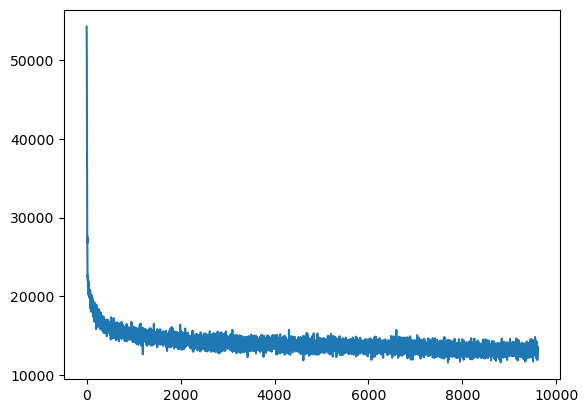

In [57]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)


In [58]:
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])
print(z_tensor.size())   #torch.Size([9600, 100, 2])
print(labels_tensor.size())   #torch.Size([9600, 100])

z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(z_np.shape)   #(9600, 100, 2)
print(labels_np.shape)   #(9600, 100)


torch.Size([9600, 100, 2])
torch.Size([9600, 100])
(9600, 100, 2)
(9600, 100)


# 学習前の潜在変数

torch.Size([9600, 100, 2])
torch.Size([9600, 100])
(9600, 100, 2)
(9600, 100)


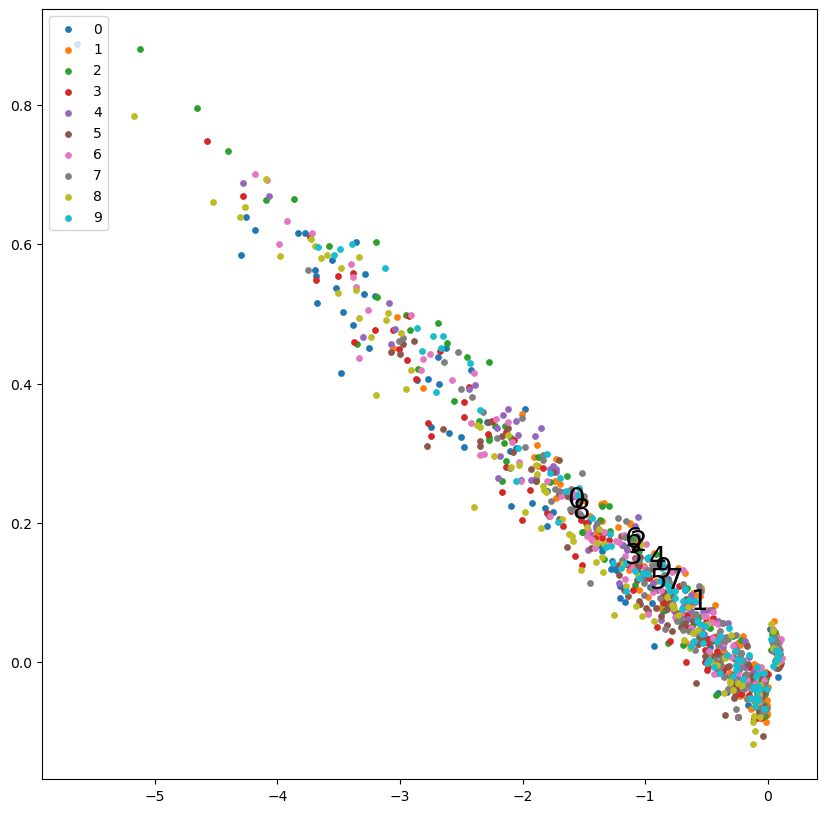

In [59]:
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])
print(z_tensor.size())
print(labels_tensor.size())

z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(z_np.shape)
print(labels_np.shape)

cmap_keyword = "tab10"
cmap = plt.get_cmap(cmap_keyword)

batch_num =10

plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[:batch_num,:,0][labels_np[:batch_num,:] == label]
  y = z_np[:batch_num,:,1][labels_np[:batch_num,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")


# 学習後の潜在変数
## 学習前では規則性がなかったが、学習後ではラベルごとにデータが固まっていることが分かる

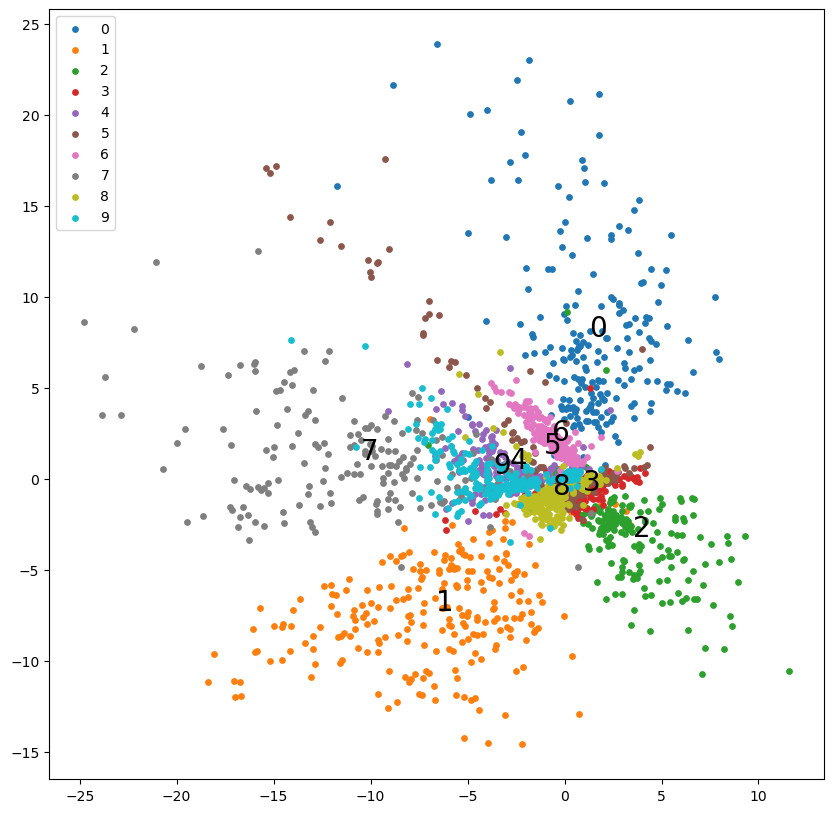

In [60]:
batch_num = 9580

plt.figure(figsize=[10,10])

for label in range(10):
  x = z_np[batch_num:,:,0][labels_np[batch_num:,:] == label]
  y = z_np[batch_num:,:,1][labels_np[batch_num:,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")


# 0の潜在変数の平均値をデコーダに入力し、画像を生成
## 0っぽい画像が生成される

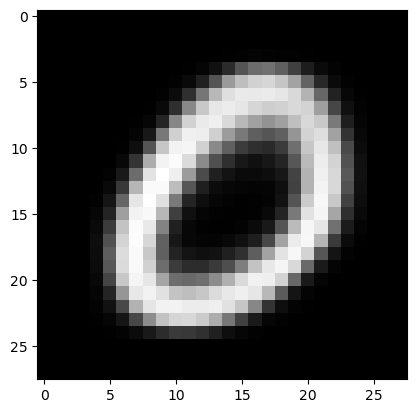

In [61]:
model.to("cpu")

label = 0
x_zero_mean = np.mean(z_np[batch_num:,:,0][labels_np[batch_num:,:] == label])
y_zero_mean = np.mean(z_np[batch_num:,:,1][labels_np[batch_num:,:] == label])
z_zero = torch.tensor([x_zero_mean,y_zero_mean], dtype = torch.float32)

output = model.decoder(z_zero)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')
